In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pickle
import optuna

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as r2

import warnings

warnings.filterwarnings('ignore')

# Предобработка и генирация фичей

In [110]:
def preprocessing(df):
    df['datetime'] = df['date'] + ' ' + df['time'].astype(str)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['Month'] = df['date'].dt.strftime('%m').astype(int)
    df['day'] = df['date'].dt.strftime('%d').astype(int)
    
    k = 1
    for i in range(0 ,df.shape[0], 168):
        df.loc[i:i+167,'Week'] = k
        k += 1
    df['Week'] = df['Week'].astype(int)
    
    df = statistic_feature(df, 'day')
    df = statistic_feature(df, 'Week')
    df = lagged(df, [24, 168, 144, 48, 120, 26], 'target')
    return df.drop(['temp', 'weather_pred', 'weather_fact', 'date'], axis=1).set_index('datetime').dropna()

In [2]:
def lagged(data:pd.DataFrame, lags:list, name_column:str) -> pd.DataFrame:
    for i in lags:
        data[f'{name_column}_lag{i}'] = data[name_column].shift(periods=i)
    return data

In [37]:
def statistic_feature(df, name):
    window = 24
    if name == 'Week':
        window = 168
        
    df[f'max_last_{name}'] = df['target'].rolling(window=window).max().shift()
    df[f'min_last_{name}'] = df['target'].rolling(window=window).min().shift()
    df[f'mean_last_{name}'] = df['target'].rolling(window=window).mean().shift()
    df[f'median_last_{name}'] = df['target'].rolling(window=window).median().shift()
    df[f'std_last_{name}'] = df['target'].rolling(window=window).std().shift()
    df[f'q25_last_{name}'] = df['target'].rolling(window=window).quantile(0.25).shift()
    df[f'q75_last_{name}'] = df['target'].rolling(window=window).quantile(0.75).shift()
    return df

In [3]:
df_train = pd.read_csv('./data/train_dataset.csv')
df_test = pd.read_csv('./data/test_dataset.csv')

In [3]:
df = pd.concat([df_train, df_test], ignore_index=True)
test_size = df_test.shape[0]

In [40]:
df = preprocessing(df)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39872 entries, 2019-01-08 0 to 2023-07-31 23
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              39872 non-null  int64  
 1   target            39872 non-null  float64
 2   temp_pred         39872 non-null  float64
 3   Month             39872 non-null  int32  
 4   day               39872 non-null  int32  
 5   Week              39872 non-null  int32  
 6   max_last_day      39872 non-null  float64
 7   min_last_day      39872 non-null  float64
 8   mean_last_day     39872 non-null  float64
 9   median_last_day   39872 non-null  float64
 10  std_last_day      39872 non-null  float64
 11  q25_last_day      39872 non-null  float64
 12  q75_last_day      39872 non-null  float64
 13  max_last_Week     39872 non-null  float64
 14  min_last_Week     39872 non-null  float64
 15  mean_last_Week    39872 non-null  float64
 16  median_last_Week  39872 no

In [53]:
train_size = df.shape[0] - test_size
df_tr, df_t = df.iloc[:train_size,:], df.iloc[train_size:,:]
print(df_tr.shape, df_t.shape)
X = df_tr.drop(['target'], axis=1)
X_test = df_t.drop(['target'], axis=1)
y = df_tr.iloc[:,1:2]
y_test = df_t.iloc[:,1:2]

(36944, 26) (2928, 26)


# Подбор параметров и обучение модели

In [ ]:
def objective(trial):
    train_size = int(len(X) * 0.8)
    X_tr, X_val, y_tr, y_val = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

    param = {
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]
        ),
        'n_estimators': trial.suggest_int(
            "n_estimators", 150, 3000
        ),
        'max_depth': trial.suggest_int(
            'max_depth', 4,17
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        )
    }
    model = XGBRegressor(**param)
    model.fit(X_tr,y_tr)
    preds_test = model.predict(X_val)
    preds_train = model.predict(X_tr)
    score_test = mae(y_val, preds_test)
    score_train = mae(y_tr, preds_train)

    return abs(score_test - score_train) * score_test / score_train

In [ ]:
study_xg = optuna.create_study(direction="minimize")
study_xg.optimize(objective, n_trials=50)

In [81]:
params_xg = {'lambda': 4.627871532483157, 
             'alpha': 3.423457570486527, 
             'colsample_bytree': 0.9, 
             'subsample': 0.7, 
             'learning_rate': 0.02, 
             'n_estimators': 2461, 
             'max_depth': 11, 
             'min_child_weight': 232}
xgb = XGBRegressor(**params_xg)
xgb = xgb.fit(X, y)

# Значимость признаков

In [65]:
def feature_importance(model):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(15,8))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(df_tr.drop(['target'],axis=1).columns)[sorted_idx])
    plt.title('Feature Importance')

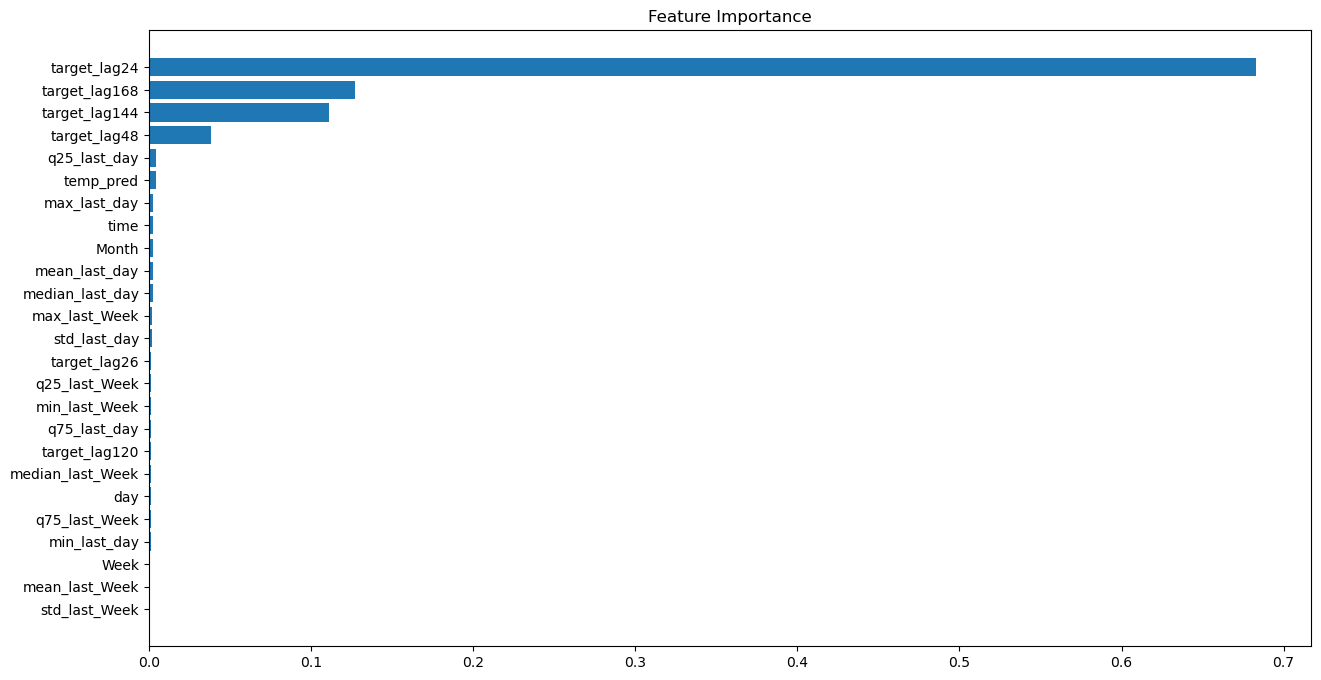

In [67]:
feature_importance(xgb)

# Метрика mae на валидации

In [60]:
def time_cross_validate(x, y, model, n_folds = 14):
    errors_test = []
    errors_train = []
    step = int(len(x) / n_folds) - 1
    for i in range(n_folds):

        model.fit(x[: step * (1 + i)], y[: step * (1 + i)])

        predictions = model.predict(x[step * (i + 1): step * (2 + i)])
        actual = y[step * (i + 1): step * (2 + i)]
        error = mae(predictions, actual)
        print(f'MAE = {error}')
        errors_test.append(error)

        predictions = model.predict(x[: step * (1 + i)])
        actual = y[: step * (1 + i)]
        error = mae(predictions, actual)
        errors_train.append(error)
    print(f'Среднее MAE = {np.mean(np.array(errors_test))}')
    return errors_train, errors_test

In [58]:
def validate_plot(errors_train, errors_test):
    plt.grid(True)
    plt.plot([x for x in range(len(errors_train))], errors_train, color = 'red', label = 'train')
    plt.plot([x for x in range(len(errors_test))], errors_test, color = 'blue', label = 'test')
    plt.xlim(0)
    plt.legend()
    plt.show()

In [62]:
errors_train, errors_test = time_cross_validate(X, y, XGBRegressor(**params_xg))

MAE = 29.851580582423058
MAE = 14.918183886311386
MAE = 12.53351166292262
MAE = 14.62831934001114
MAE = 10.850539366495351
MAE = 16.48675074556862
MAE = 13.509296882110355
MAE = 6.374102657105465
MAE = 10.73353539983513
MAE = 12.592818593609275
MAE = 7.304278837757305
MAE = 7.856970253821072
MAE = 10.500648136883918
MAE = 4.43803771972657
Среднее MAE = 12.327041004612946


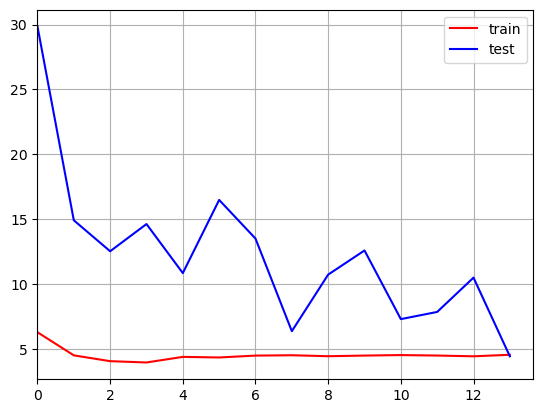

In [63]:
validate_plot(errors_train, errors_test)

# Метрики

In [68]:
def metrics(name, X, y, X_test, y_test, model):
    m = {"R2_train":{},"MAE_train":{},"MAPE_train":{}, "R2_test":{},"MAE_test":{},"MAPE_test":{}}
    m["R2_train"][name] = r2(y, model.predict(X))
    m["MAE_train"][name] = mae(y, model.predict(X))
    m["MAPE_train"][name] = mape(y, model.predict(X))
    m["R2_test"][name] = r2(y_test, model.predict(X_test))
    m["MAE_test"][name] = mae(y_test, model.predict(X_test))
    m["MAPE_test"][name] = mape(y_test, model.predict(X_test))
    return pd.DataFrame(m)

In [103]:
def match_pot(X, y, model, name): 
    fig = plt.figure(figsize=(25,6))
    plt.grid(True)
    plt.title(name)
    plt.plot(list(y['target'])[:500], color = 'red', label = 'true')
    plt.plot(model.predict(X)[:500], color = 'blue', label = 'predict')
    plt.legend()
    plt.show()

In [69]:
metrics('XGBoost', X, y, X_test, y_test, xgb)

,R2_train,MAE_train,MAPE_train,R2_test,MAE_test,MAPE_test
XGBoost,0.996118,4.536286,0.009644,0.982566,6.810467,0.01621


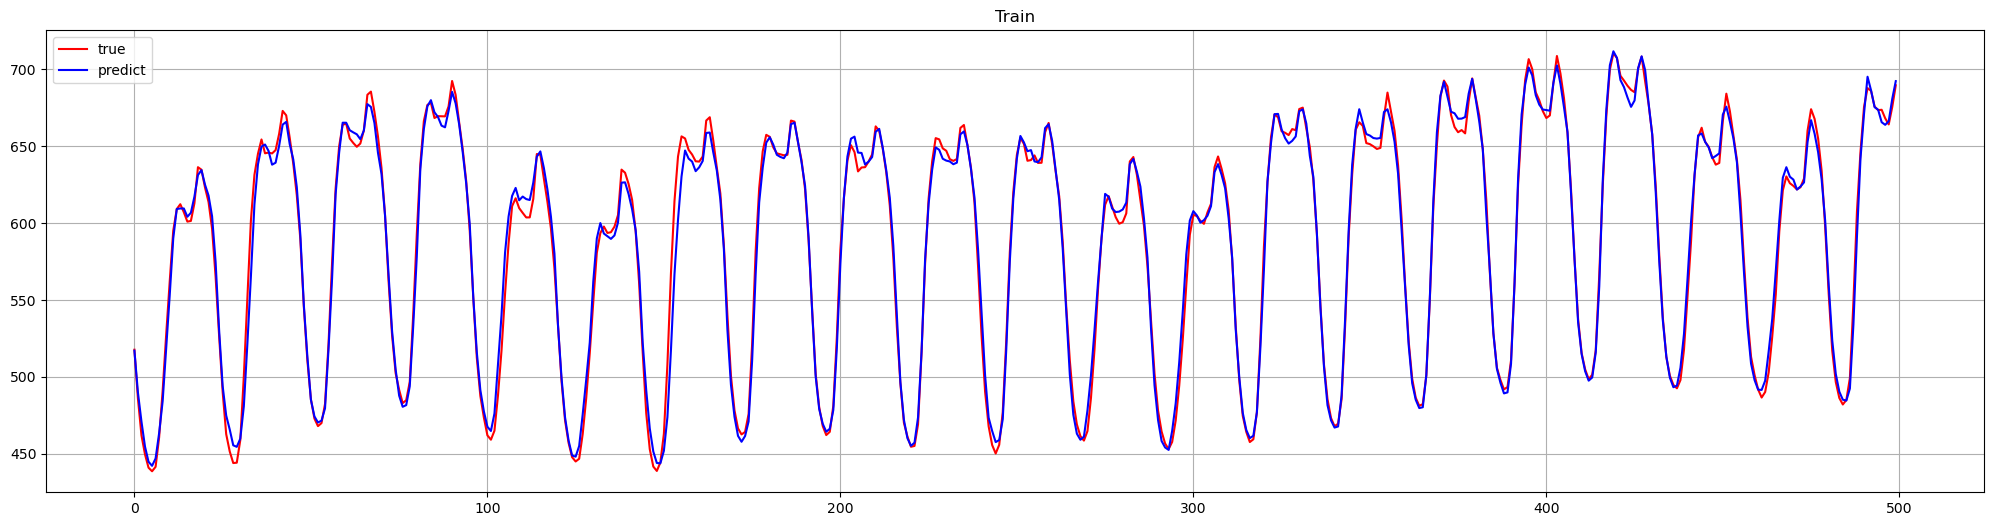

In [104]:
match_pot(X, y, xgb, 'Train')

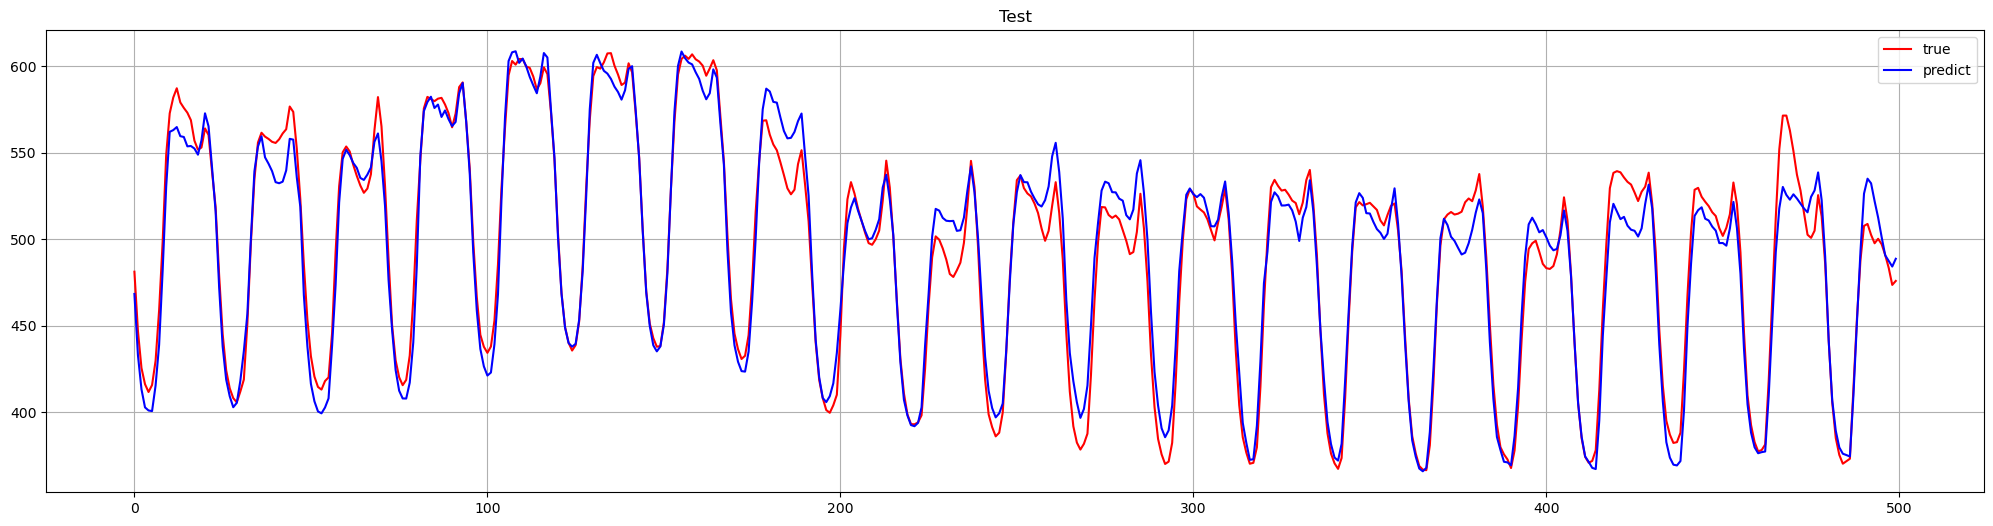

In [105]:
match_pot(X_test, y_test, xgb, 'Test')

# Обучение на всех данных

In [106]:
X_all = df.drop(['target'], axis=1)
y_all = df.iloc[:,1:2]

In [107]:
xgb = XGBRegressor(**params_xg)
xgb.fit(X_all, y_all)
y_pred = xgb.predict(X_all)

In [108]:
print(f'r2 = {r2(y_all, y_pred)}')
print(f'mae = {mae(y_all, y_pred)}')
print(f'mape = {mape(y_all, y_pred)}')

r2 = 0.9961046209177175
mae = 4.520107630256664
mape = 0.009675574321561726


In [109]:
pkl_filename = "xgboost.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb, file)

In [23]:
print(f"r2 = {r2(df['target'], y_pred['predict'])}")
print(f"mae = {mae(df['target'], y_pred['predict'])}")
print(f"mape = {mape(df['target'], y_pred['predict'])}")

r2 = 0.9961046208547399
mae = 4.52010768358748
mape = 0.009675574416587457
